# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:

A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. 

The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray


Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [10]:
import os
import ray
import glob
import eli5

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [11]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [12]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [13]:
ray.nodes()

[{'NodeID': '38ab50bb07fe79aa666df3587d59570830ca7d4c43d26df97db60ca9',
  'Alive': True,
  'NodeManagerAddress': '100.64.72.245',
  'NodeManagerHostname': 'ray-6806d3a540cc38111a1db8ca-ray-head-0',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-04-21_16-26-26_225581_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2025-04-21_16-26-26_225581_1/sockets/raylet',
  'MetricsExportPort': 49686,
  'NodeName': '100.64.72.245',
  'alive': True,
  'Resources': {'memory': 9427171739.0,
   'node:100.64.72.245': 1.0,
   'object_store_memory': 4713585868.0}},
 {'NodeID': '14a74518dac3deddea9416f214a2e04112916e19f6db313fe3b21af7',
  'Alive': True,
  'NodeManagerAddress': '100.64.95.85',
  'NodeManagerHostname': 'ray-6806d3a540cc38111a1db8ca-ray-worker-1',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-04-21_16-26-26_225581_1/sockets/plasma_store',
  'RayletSocketName':

Now let's create a list of all the shards for our training, validation, and test sets.

In [14]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [15]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [16]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [17]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [18]:
# Set a few hyperparameters to specific values
param = {
    "seed":1234,
    "max_depth":3,
    "eta":0.1,
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Train the model
evals_result = {}

bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=True,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

print("Final training error: {:.4f}".format(evals_result["train"]["error"][-1]))
print("Final validation error: {:.4f}".format(evals_result["val"]["error"][-1]))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=740) 2025-04-21 16:48:36,739	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=740) 2025-04-21 16:48:52,061	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=171, ip=100.64.22.174) [16:48:52] task [xgboost.ray]:137562257628800 got new rank 0
(_RemoteRayXGBoostActor pid=212, ip=100.64.68.38) [16:48:52] task [xgboost.ray]:140084548329536 got new rank 1
(_RemoteRayXGBoostActor pid=173, ip=100.64.95.85) [16:48:52] task [xgboost.ray]:138192042605440 got new rank 2


(_wrapped pid=740) [0]	train-logloss:0.65890	train-error:0.22747	val-logloss:0.65631	val-error:0.20883
(_wrapped pid=740) [1]	train-logloss:0.63109	train-error:0.22331	val-logloss:0.62514	val-error:0.20021
(_wrapped pid=740) [2]	train-logloss:0.60870	train-error:0.22340	val-logloss:0.60081	val-error:0.20959
(_wrapped pid=740) [3]	train-logloss:0.58690	train-error:0.18629	val-logloss:0.57680	val-error:0.15792
(_wrapped pid=740) [4]	train-logloss:0.56898	train-error:0.19034	val-logloss:0.55650	val-error:0.16499
(_wrapped pid=740) [5]	train-logloss:0.55210	train-error:0.20139	val-logloss:0.53913	val-error:0.17972
(_wrapped pid=740) [6]	train-logloss:0.53646	train-error:0.18746	val-logloss:0.52258	val-error:0.16193
(_wrapped pid=740) [7]	train-logloss:0.52353	train-error:0.18899	val-logloss:0.50922	val-error:0.16659
(_wrapped pid=740) [8]	train-logloss:0.51097	train-error:0.17833	val-logloss:0.49647	val-error:0.15485
(_wrapped pid=740) [9]	train-logloss:0.50000	train-error:0.16964	val-logl

(_wrapped pid=740) 2025-04-21 16:49:22,796	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(_wrapped pid=740) [26]	train-logloss:0.37518	train-error:0.12725	val-logloss:0.36113	val-error:0.11739
(_wrapped pid=740) [27]	train-logloss:0.37013	train-error:0.12735	val-logloss:0.35584	val-error:0.11820
(_wrapped pid=740) [28]	train-logloss:0.36639	train-error:0.12081	val-logloss:0.35223	val-error:0.11037
(_wrapped pid=740) [29]	train-logloss:0.36194	train-error:0.12386	val-logloss:0.34761	val-error:0.11433
(_wrapped pid=740) [30]	train-logloss:0.35791	train-error:0.12588	val-logloss:0.34378	val-error:0.11668
(_wrapped pid=740) [31]	train-logloss:0.35449	train-error:0.12364	val-logloss:0.34068	val-error:0.11434
(_wrapped pid=740) [32]	train-logloss:0.35040	train-error:0.11787	val-logloss:0.33605	val-error:0.10798
(_wrapped pid=740) [33]	train-logloss:0.34684	train-error:0.11448	val-logloss:0.33241	val-error:0.10723
(_wrapped pid=740) [34]	train-logloss:0.34377	train-error:0.11517	val-logloss:0.32920	val-error:0.10568
(_wrapped pid=740) [35]	train-logloss:0.33971	train-error:0.1136

(_wrapped pid=740) 2025-04-21 16:49:42,931	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 68.45 seconds (50.86 pure XGBoost training time).


Final training error: 0.0941
Final validation error: 0.0876


Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [19]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [20]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Demo-Credit-Default-Model/ray_results


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [21]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [22]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the TUNE_ROOT directory

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [23]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=TUNE_ROOT,
    metric="val-error",
    mode="min",
    num_samples=10,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

(run pid=1086) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=296, ip=100.64.22.174) [16:50:11] task [xgboost.ray]:138039916071760 got new rank 0
(_RemoteRayXGBoostActor pid=296, ip=100.64.68.38) [16:50:11] task [xgboost.ray]:132257527033760 got new rank 1
(_RemoteRayXGBoostActor pid=254, ip=100.64.95.85) [16:50:11] task [xgboost.ray]:133218896646048 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.68410	train-error:0.16109	val-logloss:0.68398	val-error:0.15954
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.67541	train-error:0.15846	val-logloss:0.67523	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.66695	train-error:0.15846	val-logloss:0.66665	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.65895	train-error:0.15859	val-logloss:0.65805	val-error:0.15489
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.65099	train-error:0.16006	val-logloss:0.64996	val-error:0.15804
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.64343	train-error:0.15635	val-logloss:0.64178	val-error:0.15176
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.63607	train-error:0.15254	val-logloss:0.63387	val-error:0.14009
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.62894	train-error:0.14858	val-logloss:0.62617	val-error:0.13619
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:50:41,716	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [28]	train-logloss:0.51238	train-error:0.12362	val-logloss:0.50254	val-error:0.11123
(my_trainer pid=253, ip=100.64.22.174) [29]	train-logloss:0.50822	train-error:0.12487	val-logloss:0.49813	val-error:0.11440
(my_trainer pid=253, ip=100.64.22.174) [30]	train-logloss:0.50361	train-error:0.11968	val-logloss:0.49338	val-error:0.10810
(my_trainer pid=253, ip=100.64.22.174) [31]	train-logloss:0.49955	train-error:0.12136	val-logloss:0.48895	val-error:0.10966
(my_trainer pid=253, ip=100.64.22.174) [32]	train-logloss:0.49520	train-error:0.11943	val-logloss:0.48454	val-error:0.10810
(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.49059	train-error:0.11842	val-logloss:0.47985	val-error:0.10731
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.48638	train-error:0.11910	val-logloss:0.47550	val-error:0.10567
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.48229	train-error:0.11808	val-logloss:0.47134	val-error:0.10491
(my_trai

(_RemoteRayXGBoostActor pid=442, ip=100.64.22.174) [16:51:05] task [xgboost.ray]:129988673005264 got new rank 0
(_RemoteRayXGBoostActor pid=418, ip=100.64.68.38) [16:51:05] task [xgboost.ray]:128799632930704 got new rank 1
(_RemoteRayXGBoostActor pid=376, ip=100.64.95.85) [16:51:05] task [xgboost.ray]:123659962708128 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.67753	train-error:0.22747	val-logloss:0.67638	val-error:0.20883
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.66366	train-error:0.22331	val-logloss:0.66091	val-error:0.20021
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.65092	train-error:0.21114	val-logloss:0.64656	val-error:0.18773
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.63840	train-error:0.21758	val-logloss:0.63303	val-error:0.19398
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.62776	train-error:0.21565	val-logloss:0.62151	val-error:0.20100
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.61744	train-error:0.20920	val-logloss:0.60997	val-error:0.19554
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.60814	train-error:0.20672	val-logloss:0.59969	val-error:0.19316
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.59866	train-error:0.20423	val-logloss:0.58952	val-error:0.18924
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:51:35,504	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [32]	train-logloss:0.46031	train-error:0.16050	val-logloss:0.44641	val-error:0.14790
(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.45679	train-error:0.15580	val-logloss:0.44272	val-error:0.14478
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.45307	train-error:0.15590	val-logloss:0.43915	val-error:0.14557
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.44979	train-error:0.15983	val-logloss:0.43584	val-error:0.14870
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.44676	train-error:0.15750	val-logloss:0.43280	val-error:0.14481
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.44270	train-error:0.16257	val-logloss:0.42870	val-error:0.14868
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.43949	train-error:0.15242	val-logloss:0.42545	val-error:0.14087
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.43603	train-error:0.15139	val-logloss:0.42214	val-error:0.14015
(my_trai

(_RemoteRayXGBoostActor pid=664, ip=100.64.22.174) [16:51:57] task [xgboost.ray]:135374029184640 got new rank 0
(_RemoteRayXGBoostActor pid=501, ip=100.64.68.38) [16:51:57] task [xgboost.ray]:126641300529312 got new rank 1
(_RemoteRayXGBoostActor pid=499, ip=100.64.95.85) [16:51:57] task [xgboost.ray]:131130093086272 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.68090	train-error:0.16109	val-logloss:0.68074	val-error:0.15954
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.66926	train-error:0.15846	val-logloss:0.66902	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.65801	train-error:0.16375	val-logloss:0.65758	val-error:0.16435
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.64748	train-error:0.16257	val-logloss:0.64620	val-error:0.15962
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.63741	train-error:0.15189	val-logloss:0.63537	val-error:0.14641
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.62756	train-error:0.14603	val-logloss:0.62470	val-error:0.13152
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.61790	train-error:0.15153	val-logloss:0.61486	val-error:0.13858
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.60877	train-error:0.14580	val-logloss:0.60513	val-error:0.12920
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:52:27,983	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [32]	train-logloss:0.44970	train-error:0.12068	val-logloss:0.43802	val-error:0.10417
(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.44508	train-error:0.11775	val-logloss:0.43324	val-error:0.10106
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.44051	train-error:0.11573	val-logloss:0.42853	val-error:0.10106
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.43603	train-error:0.11775	val-logloss:0.42389	val-error:0.10025
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.43165	train-error:0.11324	val-logloss:0.41934	val-error:0.09555
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.42747	train-error:0.11125	val-logloss:0.41496	val-error:0.09404
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.42321	train-error:0.11212	val-logloss:0.41050	val-error:0.09318
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.41907	train-error:0.10579	val-logloss:0.40632	val-error:0.08772
(my_trai

(_RemoteRayXGBoostActor pid=848, ip=100.64.22.174) [16:52:48] task [xgboost.ray]:136713585683328 got new rank 0
(_RemoteRayXGBoostActor pid=623, ip=100.64.68.38) [16:52:48] task [xgboost.ray]:126913469877888 got new rank 1
(_RemoteRayXGBoostActor pid=621, ip=100.64.95.85) [16:52:49] task [xgboost.ray]:132389411623024 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.68727	train-error:0.16109	val-logloss:0.68720	val-error:0.15954
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.68152	train-error:0.16109	val-logloss:0.68143	val-error:0.15954
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.67593	train-error:0.15846	val-logloss:0.67574	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.67046	train-error:0.15846	val-logloss:0.67023	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.66505	train-error:0.15846	val-logloss:0.66473	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.65989	train-error:0.16153	val-logloss:0.65917	val-error:0.15960
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.65484	train-error:0.15700	val-logloss:0.65376	val-error:0.15573
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.64986	train-error:0.15589	val-logloss:0.64838	val-error:0.15176
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:53:19,735	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [32]	train-logloss:0.54808	train-error:0.13240	val-logloss:0.54079	val-error:0.11832
(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.54488	train-error:0.13139	val-logloss:0.53732	val-error:0.11753
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.54168	train-error:0.12789	val-logloss:0.53399	val-error:0.11437
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.53837	train-error:0.12789	val-logloss:0.53055	val-error:0.11437
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.53533	train-error:0.12790	val-logloss:0.52731	val-error:0.11437
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.53222	train-error:0.12848	val-logloss:0.52402	val-error:0.11516
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.52924	train-error:0.12554	val-logloss:0.52081	val-error:0.11123
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.52624	train-error:0.12554	val-logloss:0.51750	val-error:0.11123
(my_trai

(_RemoteRayXGBoostActor pid=1070, ip=100.64.22.174) [16:53:40] task [xgboost.ray]:137735567184032 got new rank 0
(_RemoteRayXGBoostActor pid=706, ip=100.64.68.38) [16:53:40] task [xgboost.ray]:139607114002496 got new rank 1
(_RemoteRayXGBoostActor pid=744, ip=100.64.95.85) [16:53:40] task [xgboost.ray]:123257512999808 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.64294	train-error:0.30285	val-logloss:0.63980	val-error:0.29079
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.60868	train-error:0.28383	val-logloss:0.60230	val-error:0.24184
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.57902	train-error:0.25183	val-logloss:0.57073	val-error:0.23058
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.55404	train-error:0.23132	val-logloss:0.54620	val-error:0.21886
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.53483	train-error:0.22475	val-logloss:0.52600	val-error:0.21656
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.51895	train-error:0.22264	val-logloss:0.50938	val-error:0.21111
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.50433	train-error:0.20503	val-logloss:0.49572	val-error:0.19545
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.48982	train-error:0.19626	val-logloss:0.47929	val-error:0.18450
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:54:11,352	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.33579	train-error:0.12585	val-logloss:0.32491	val-error:0.12041
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.33289	train-error:0.12969	val-logloss:0.32288	val-error:0.12354
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.33020	train-error:0.12180	val-logloss:0.31991	val-error:0.11813
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.32805	train-error:0.11941	val-logloss:0.31690	val-error:0.11423
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.32526	train-error:0.12411	val-logloss:0.31450	val-error:0.12041
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.32270	train-error:0.12322	val-logloss:0.31190	val-error:0.11883
(my_trainer pid=253, ip=100.64.22.174) [40]	train-logloss:0.32121	train-error:0.12233	val-logloss:0.31007	val-error:0.11728
(my_trainer pid=253, ip=100.64.22.174) [41]	train-logloss:0.31995	train-error:0.12243	val-logloss:0.30855	val-error:0.11731
(my_trai

(_RemoteRayXGBoostActor pid=1256, ip=100.64.22.174) [16:54:29] task [xgboost.ray]:136812593275040 got new rank 0
(_RemoteRayXGBoostActor pid=828, ip=100.64.68.38) [16:54:29] task [xgboost.ray]:126656334952384 got new rank 1
(_RemoteRayXGBoostActor pid=863, ip=100.64.95.85) [16:54:30] task [xgboost.ray]:133917617199952 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.66643	train-error:0.30285	val-logloss:0.66485	val-error:0.29079
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.64440	train-error:0.26686	val-logloss:0.64097	val-error:0.24841
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.62565	train-error:0.26377	val-logloss:0.62058	val-error:0.24140
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.60898	train-error:0.25963	val-logloss:0.60226	val-error:0.24305
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.59406	train-error:0.25796	val-logloss:0.58752	val-error:0.24541
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.58101	train-error:0.24815	val-logloss:0.57358	val-error:0.22265
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.56900	train-error:0.24894	val-logloss:0.56069	val-error:0.23061
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.55836	train-error:0.23953	val-logloss:0.55016	val-error:0.21867
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:55:00,742	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.41129	train-error:0.15272	val-logloss:0.39918	val-error:0.14233
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.40774	train-error:0.15499	val-logloss:0.39534	val-error:0.14317
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.40509	train-error:0.15015	val-logloss:0.39321	val-error:0.13925
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.40222	train-error:0.14913	val-logloss:0.39027	val-error:0.14238
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.39884	train-error:0.14707	val-logloss:0.38650	val-error:0.14006
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.39688	train-error:0.14595	val-logloss:0.38445	val-error:0.13850
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.39380	train-error:0.14696	val-logloss:0.38123	val-error:0.13775
(my_trainer pid=253, ip=100.64.22.174) [40]	train-logloss:0.39127	train-error:0.14650	val-logloss:0.37915	val-error:0.13931
(my_trai

(_RemoteRayXGBoostActor pid=1478, ip=100.64.22.174) [16:55:19] task [xgboost.ray]:124908567593072 got new rank 0
(_RemoteRayXGBoostActor pid=910, ip=100.64.68.38) [16:55:19] task [xgboost.ray]:128217610117328 got new rank 1
(_RemoteRayXGBoostActor pid=946, ip=100.64.95.85) [16:55:19] task [xgboost.ray]:123684832536368 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.69105	train-error:0.30285	val-logloss:0.69093	val-error:0.29079
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.68898	train-error:0.30285	val-logloss:0.68875	val-error:0.29079
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.68695	train-error:0.30285	val-logloss:0.68660	val-error:0.29079
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.68495	train-error:0.26686	val-logloss:0.68445	val-error:0.24841
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.68298	train-error:0.26686	val-logloss:0.68237	val-error:0.24841
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.68104	train-error:0.26686	val-logloss:0.68028	val-error:0.24841
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.67912	train-error:0.26686	val-logloss:0.67826	val-error:0.24841
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.67724	train-error:0.26686	val-logloss:0.67623	val-error:0.24841
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:55:50,348	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.63629	train-error:0.26627	val-logloss:0.63219	val-error:0.25401
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.63497	train-error:0.26627	val-logloss:0.63075	val-error:0.25401
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.63359	train-error:0.26627	val-logloss:0.62925	val-error:0.25401
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.63229	train-error:0.26627	val-logloss:0.62787	val-error:0.25401
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.63093	train-error:0.26008	val-logloss:0.62641	val-error:0.24538
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.62966	train-error:0.26008	val-logloss:0.62505	val-error:0.24538
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.62833	train-error:0.26380	val-logloss:0.62361	val-error:0.24935
(my_trainer pid=253, ip=100.64.22.174) [40]	train-logloss:0.62707	train-error:0.26380	val-logloss:0.62228	val-error:0.24935
(my_trai

(_RemoteRayXGBoostActor pid=1664, ip=100.64.22.174) [16:56:09] task [xgboost.ray]:134666541090800 got new rank 0
(_RemoteRayXGBoostActor pid=991, ip=100.64.68.38) [16:56:09] task [xgboost.ray]:133211196630640 got new rank 1
(_RemoteRayXGBoostActor pid=1068, ip=100.64.95.85) [16:56:09] task [xgboost.ray]:127177873444768 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.63732	train-error:0.20367	val-logloss:0.63512	val-error:0.19787
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.59473	train-error:0.18088	val-logloss:0.58824	val-error:0.17130
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.55955	train-error:0.17709	val-logloss:0.55080	val-error:0.16193
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.52974	train-error:0.17885	val-logloss:0.51955	val-error:0.16361
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.50187	train-error:0.16882	val-logloss:0.49059	val-error:0.14937
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.48135	train-error:0.15934	val-logloss:0.46968	val-error:0.13928
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.46098	train-error:0.15098	val-logloss:0.44975	val-error:0.13462
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.44275	train-error:0.14330	val-logloss:0.42987	val-error:0.12753
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:56:39,611	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [31]	train-logloss:0.24430	train-error:0.06514	val-logloss:0.23004	val-error:0.05560
(my_trainer pid=253, ip=100.64.22.174) [32]	train-logloss:0.23960	train-error:0.06234	val-logloss:0.22594	val-error:0.05246
(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.23620	train-error:0.06256	val-logloss:0.22283	val-error:0.05088
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.23180	train-error:0.06334	val-logloss:0.21898	val-error:0.05399
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.22978	train-error:0.06334	val-logloss:0.21676	val-error:0.05399
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.22470	train-error:0.06198	val-logloss:0.21207	val-error:0.05322
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.22194	train-error:0.06254	val-logloss:0.20932	val-error:0.05243
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.21927	train-error:0.05917	val-logloss:0.20689	val-error:0.04773
(my_trai

(_RemoteRayXGBoostActor pid=1890, ip=100.64.22.174) [16:57:00] task [xgboost.ray]:139887143569344 got new rank 0
(_RemoteRayXGBoostActor pid=1111, ip=100.64.68.38) [16:57:00] task [xgboost.ray]:127038156439712 got new rank 1
(_RemoteRayXGBoostActor pid=1150, ip=100.64.95.85) [16:57:00] task [xgboost.ray]:131845283751872 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.69004	train-error:0.16109	val-logloss:0.69000	val-error:0.15954
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.68696	train-error:0.16109	val-logloss:0.68691	val-error:0.15954


(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.68392	train-error:0.16109	val-logloss:0.68383	val-error:0.15954
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.68094	train-error:0.15997	val-logloss:0.68083	val-error:0.15799
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.67796	train-error:0.15997	val-logloss:0.67782	val-error:0.15799
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.67504	train-error:0.15846	val-logloss:0.67487	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.67216	train-error:0.15846	val-logloss:0.67194	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.66927	train-error:0.15846	val-logloss:0.66900	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [8]	train-logloss:0.66645	train-error:0.15846	val-logloss:0.66613	val-error:0.15730
(my_trainer pid=253, ip=100.64.22.174) [9]	train-logloss:0.66370	train-error:0.15815	val-logloss:0.66317	val-error:0.15489
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:57:31,402	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [32]	train-logloss:0.60681	train-error:0.13658	val-logloss:0.60262	val-error:0.11985
(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.60457	train-error:0.13613	val-logloss:0.60031	val-error:0.11910
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.60240	train-error:0.13816	val-logloss:0.59798	val-error:0.12065
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.60021	train-error:0.13061	val-logloss:0.59571	val-error:0.11519
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.59807	train-error:0.12993	val-logloss:0.59343	val-error:0.11284
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.59590	train-error:0.12902	val-logloss:0.59119	val-error:0.11284
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.59382	train-error:0.12902	val-logloss:0.58898	val-error:0.11284
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.59169	train-error:0.12744	val-logloss:0.58678	val-error:0.11129
(my_trai

(_RemoteRayXGBoostActor pid=2075, ip=100.64.22.174) [16:57:52] task [xgboost.ray]:126415454318704 got new rank 0
(_RemoteRayXGBoostActor pid=1191, ip=100.64.68.38) [16:57:52] task [xgboost.ray]:123942068971504 got new rank 1
(_RemoteRayXGBoostActor pid=1231, ip=100.64.95.85) [16:57:52] task [xgboost.ray]:127271445130112 got new rank 2


(my_trainer pid=253, ip=100.64.22.174) [0]	train-logloss:0.60825	train-error:0.20367	val-logloss:0.60486	val-error:0.19787
(my_trainer pid=253, ip=100.64.22.174) [1]	train-logloss:0.55110	train-error:0.18401	val-logloss:0.54342	val-error:0.16815
(my_trainer pid=253, ip=100.64.22.174) [2]	train-logloss:0.50658	train-error:0.16998	val-logloss:0.49746	val-error:0.15654
(my_trainer pid=253, ip=100.64.22.174) [3]	train-logloss:0.46643	train-error:0.16379	val-logloss:0.45639	val-error:0.14698
(my_trainer pid=253, ip=100.64.22.174) [4]	train-logloss:0.43905	train-error:0.14567	val-logloss:0.42787	val-error:0.13224
(my_trainer pid=253, ip=100.64.22.174) [5]	train-logloss:0.41378	train-error:0.13740	val-logloss:0.40324	val-error:0.12841
(my_trainer pid=253, ip=100.64.22.174) [6]	train-logloss:0.39047	train-error:0.12539	val-logloss:0.37696	val-error:0.11583
(my_trainer pid=253, ip=100.64.22.174) [7]	train-logloss:0.37206	train-error:0.12924	val-logloss:0.35829	val-error:0.11435
(my_trainer pid=

(my_trainer pid=253, ip=100.64.22.174) 2025-04-21 16:58:23,179	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=253, ip=100.64.22.174) [32]	train-logloss:0.18404	train-error:0.04538	val-logloss:0.17336	val-error:0.04070
(my_trainer pid=253, ip=100.64.22.174) [33]	train-logloss:0.18088	train-error:0.04358	val-logloss:0.17025	val-error:0.03913
(my_trainer pid=253, ip=100.64.22.174) [34]	train-logloss:0.17956	train-error:0.04121	val-logloss:0.16907	val-error:0.03604
(my_trainer pid=253, ip=100.64.22.174) [35]	train-logloss:0.17585	train-error:0.04248	val-logloss:0.16546	val-error:0.03835
(my_trainer pid=253, ip=100.64.22.174) [36]	train-logloss:0.17331	train-error:0.04214	val-logloss:0.16295	val-error:0.03912
(my_trainer pid=253, ip=100.64.22.174) [37]	train-logloss:0.17101	train-error:0.03988	val-logloss:0.16114	val-error:0.03756
(my_trainer pid=253, ip=100.64.22.174) [38]	train-logloss:0.16681	train-error:0.03626	val-logloss:0.15810	val-error:0.03600
(my_trainer pid=253, ip=100.64.22.174) [39]	train-logloss:0.16478	train-error:0.03626	val-logloss:0.15597	val-error:0.03600
(my_trai

(run pid=1086) 2025-04-21 16:58:39,635	INFO tune.py:945 -- Total run time: 532.30 seconds (517.64 seconds for the tuning loop).


Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [24]:
analysis.best_config

{'seed': 1234,
 'eta': 0.21487683070310165,
 'max_depth': 4,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [25]:
import shutil

shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

'/mnt/artifacts/tune_best.xgb'

Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [26]:
# Inference using Ray

# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))


xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

(predict pid=1086) 2025-04-21 16:58:39,808	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=1086) 2025-04-21 16:58:41,843	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.74


In [27]:
list(predictions)

[0.55478936,
 0.962152,
 0.30365986,
 0.9832486,
 0.99564266,
 0.71296793,
 0.54025114,
 0.8733542,
 0.9149233,
 0.92151713,
 0.8392141,
 0.49976325,
 0.87428164,
 0.90376234,
 0.5129759,
 0.20580834,
 0.98588574,
 0.7410749,
 0.986061,
 0.81306815,
 0.28545195,
 0.9408526,
 0.43334958,
 0.98853636,
 0.5906354,
 0.97283113,
 0.37111264,
 0.29379597,
 0.9748274,
 0.12324531,
 0.95091385,
 0.7198276,
 0.4395988,
 0.96223885,
 0.96084994,
 0.54182917,
 0.9993204,
 0.96898806,
 0.32646772,
 0.94509804,
 0.49432814,
 0.9614444,
 0.55986166,
 0.2738469,
 0.899109,
 0.5480274,
 0.98516953,
 0.7691373,
 0.41694418,
 0.9744387,
 0.90673137,
 0.9928397,
 0.93088627,
 0.9694639,
 0.9718983,
 0.06759878,
 0.98183906,
 0.8107302,
 0.92543894,
 0.9882686,
 0.65648925,
 0.86379325,
 0.65352815,
 0.25148845,
 0.77221906,
 0.5435178,
 0.9053273,
 0.30217096,
 0.15660325,
 0.5661982,
 0.9585669,
 0.72994053,
 0.6643427,
 0.98320574,
 0.88334125,
 0.76920867,
 0.3842507,
 0.3151979,
 0.9478282,
 0.937293

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [28]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.74


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

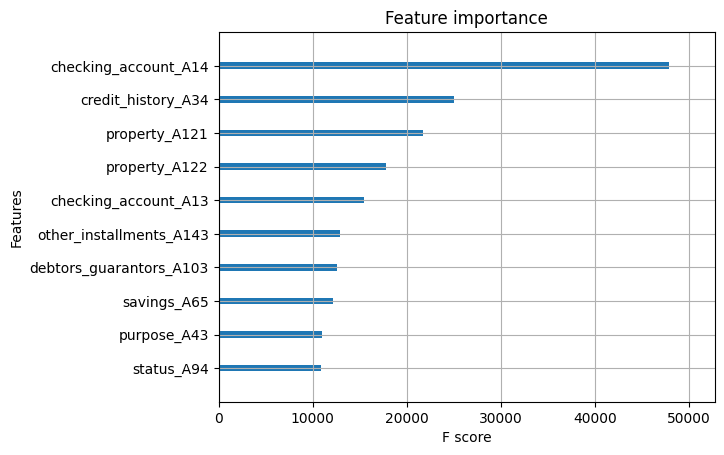

In [29]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False);

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

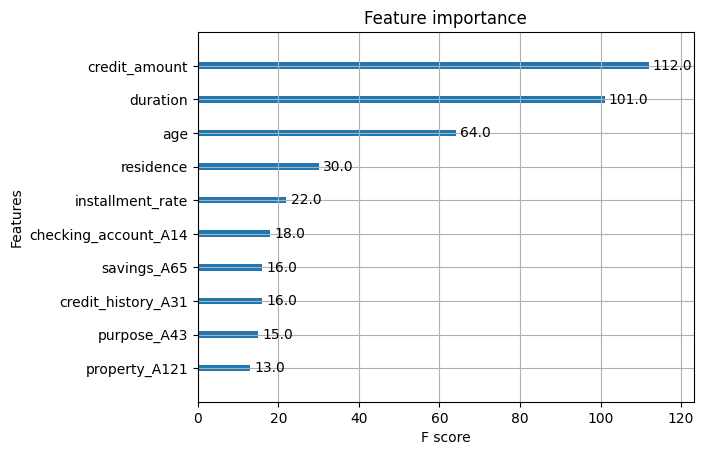

In [30]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10);

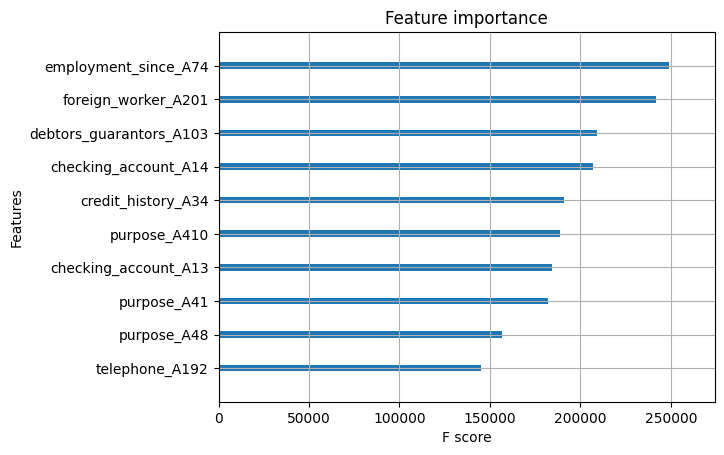

In [31]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False);

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [32]:
eli5.show_weights(xgc)

Weight,Feature
0.1128,checking_account_A14
0.0589,credit_history_A34
0.0511,property_A121
0.0418,property_A122
0.0364,checking_account_A13
0.0303,other_installments_A143
0.0296,debtors_guarantors_A103
0.0285,savings_A65
0.0258,purpose_A43
0.0257,status_A94


A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [33]:
id = 3 # <- change this to see results for different observations  

print("Actual Label: %s" % actuals.iloc[id])
print("Predicted: %s" % pred_class[id])
eli5.show_prediction(xgc, df_test_X.iloc[id], 
                     feature_names=list(df_test_X.columns),
                     show_feature_values=True)


Actual Label: 1
Predicted: 1


This concludes the model training notebook demo.

In [34]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [35]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [36]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [37]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [38]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [39]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [40]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [41]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,credit_amount,0.729366,0.368548
y,purpose_A41,0.725979,1.000000
y,age,0.721054,0.285714
y,status_A92,0.204845,0.000000
y,installment_rate,0.187911,0.333333
y,employment_since_A73,0.182714,1.000000
y,property_A123,0.116624,1.000000
y,telephone_A192,0.085379,1.000000
y,checking_account_A11,0.070691,0.000000
y,,0.027420,1.000000
